# Community detection with InfoMap and Louvain, in the painter network

The network explored is the created and filtered network in the `painter_networks.ipynb`, and is stored in the `data\painters.graphml` file.<br>
Painters are connected if (based on the dataset) they lived 5 years at the same location; periods are estimated. This is a network with extensive temporal information, with artists dating back to the middle ages all the way to the 20th century. Therefore, the network is longitudinal and connections only span to short range (painters in the same lifetime), making the network's diameter rather large (26) despite its size (2503 nodes). The network is undirected, weights are not taken into account.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time

from infomap import Infomap
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import modularity

time.sleep(1)
#Dataset of painters/artists:
#artists = pd.read_csv("data/artists.csv").drop(columns=["Type", "Contemporary"])#Type and contemporary are artificial columns

In [2]:
G = nx.read_graphml("data/painters.graphml")
print(len(list(G.nodes)), len(list(G.edges)))
print("An example of node metadata:\n")
print(G.nodes()['O. Louis Guglielmi'])

2503 20267
An example of node metadata:

{'name': 'O. Louis Guglielmi', 'artist': 'O. Louis Guglielmi', 'Nationality': 'American,Egyptian', 'citizenship': 'United States', 'gender': 'male', 'styles': 'Cubism, Expressionism, Magic Realism', 'movement': 'Social Realism', 'Art500k_Movements': '{Social Realism,Magic Realism:34}', 'birth_place': 'Cairo', 'death_place': 'Amagansett', 'birth_year': 1906.0, 'death_year': 1956.0, 'FirstYear': 1931.0, 'LastYear': 1955.0, 'wikiart_pictures_count': 34.0, 'locations': 'United States', 'locations_with_years': "['United States:1914-1914']", 'styles_extended': '{Cubism:3},{Expressionism:6},{Magic Realism:25}', 'StylesCount': '{Magic Realism:25}, {Cubism:8}, {Expressionism:6}', 'StylesYears': 'Magic Realism:1931-1946,Cubism:1946-1954,Expressionism:1952-1955', 'occupations': 'university teacher,painter', 'PaintingsExhibitedAt': '', 'PaintingsExhibitedAtCount': '', 'PaintingSchool': '', 'Influencedby': '', 'Influencedon': '', 'Pupils': '', 'Teachers': ''

## Using InfoMap and Louvain to detect communities

To detect communities in the network, two different algorithms were used: Infomap and Louvain. Initially, both algorithms are run 10 times.

In [3]:
num_trials = 10
teleportation_probability = 0.15

im_models = []
im_comms = []
im_modularities = []
for x in range(1, 10+1):
    im = Infomap(two_level=True, num_trials=num_trials+x, flow_model="undirected",
                 recorded_teleportation=False,
                 core_level_limit=2, teleportation_probability=teleportation_probability,
                 core_loop_limit=x*1000, seed=x)
    mapping = im.add_networkx_graph(G)

    im.run()
    im_models.append(im)
    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")
        
    communities = {}
    for node in im.nodes:
        module_id = node.module_id
        if module_id not in communities:
            communities[module_id] = []
        communities[module_id].append(mapping[node.node_id])
    
    communities = list(communities.values())
    im_comms.append(communities)

    modularity_value = modularity(G, communities)
    print(f"Modularity for model {x}: {modularity_value}")
    im_modularities.append(modularity_value)

Found 106 modules with codelength: 7.661727197729455
Modularity for model 1: 0.7033817300180804
Found 110 modules with codelength: 7.659533149472393
Modularity for model 2: 0.702120322664702
Found 111 modules with codelength: 7.658592015358877
Modularity for model 3: 0.7016656991118418
Found 106 modules with codelength: 7.660029152675602
Modularity for model 4: 0.7007224017383661
Found 109 modules with codelength: 7.655431559366092
Modularity for model 5: 0.7033594724013158
Found 108 modules with codelength: 7.661443573395382
Modularity for model 6: 0.7023142764212467
Found 105 modules with codelength: 7.658397241723869
Modularity for model 7: 0.7025328061631925
Found 107 modules with codelength: 7.658511702574787
Modularity for model 8: 0.7025148700952718
Found 105 modules with codelength: 7.656646603111914
Modularity for model 9: 0.7020254779393036
Found 110 modules with codelength: 7.654285770408013
Modularity for model 10: 0.6997416301587871


In [5]:
louvain_comms = []
louvain_modularities = []

for x in range(1,10+1):
    comm = louvain_communities(G, seed=x)
    louvain_comms.append(comm)
    louvain_modularities.append(modularity(G, comm))
    
    print(f"Modularity for Louvain {x}: {louvain_modularities[x-1]}")

Modularity for Louvain 1: 0.7467643095532475
Modularity for Louvain 2: 0.7464481066447269
Modularity for Louvain 3: 0.7453059537154177
Modularity for Louvain 4: 0.7426436797502118
Modularity for Louvain 5: 0.7471472471616869
Modularity for Louvain 6: 0.7435498912306429
Modularity for Louvain 7: 0.7441293160748723
Modularity for Louvain 8: 0.7431595742773321
Modularity for Louvain 9: 0.7443619034995743
Modularity for Louvain 10: 0.7438347101683227


Let's see a plot of the modularity values across the runs:

Text(0.5, 1.0, 'Infomap vs. Louvain modularity values')

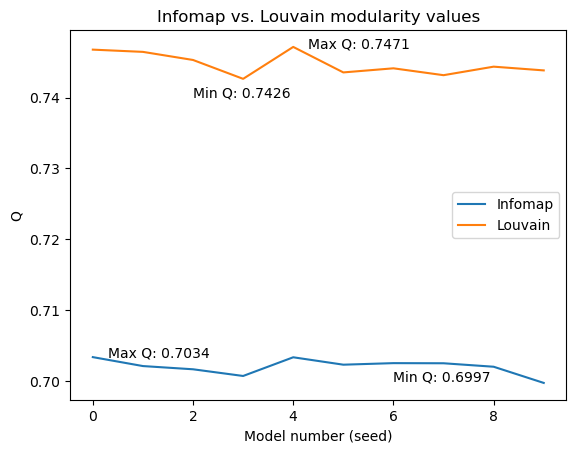

In [6]:
plt.plot(im_modularities)
plt.plot(louvain_modularities)
plt.xlabel("Model number (seed)")
plt.ylabel("Q")

plt.text(0.3, 0.7033, f"Max Q: {round(max(im_modularities),4)}")
plt.text(6, 0.7, f"Min Q: {round(min(im_modularities),4)}")


plt.text(4.3, 0.747, f"Max Q: {round(max(louvain_modularities),4)}")
plt.text(2, 0.74, f"Min Q: {round(min(louvain_modularities),4)}")

plt.legend(["Infomap", "Louvain"])
plt.title("Infomap vs. Louvain modularity values")

In [7]:
best_im = im_models[np.argmax(im_modularities)]

best_im_communities = im_comms[np.argmax(im_modularities)]
best_louvain_communities = louvain_comms[np.argmax(louvain_modularities)]

best_im_communities_lengths = [len(comm) for comm in best_im_communities]
best_louvain_communities_lengths = [len(comm) for comm in best_louvain_communities]

lowest_im = im_comms[np.argmin(im_modularities)]
lowest_im_communities= im_comms[np.argmin(im_modularities)]
lowest_im_communities_lengths = [len(comm) for comm in lowest_im_communities]

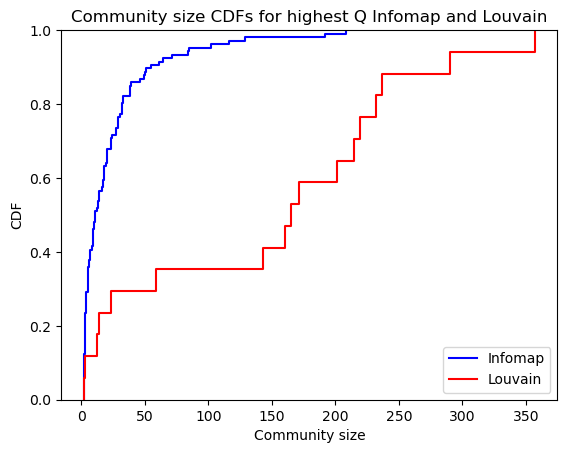

In [8]:
plt.ecdf(best_im_communities_lengths, label='CDF', color='b')
plt.ecdf(best_louvain_communities_lengths, label='CDF', color='r')
plt.xlabel("Community size")
plt.ylabel("CDF")
plt.title("Community size CDFs for highest Q Infomap and Louvain")
plt.legend(["Infomap", "Louvain"]);

As seen, Infomap captures rather "continuous" community sizes, whereas Louvain captures a heterogenous set of sizes, but more rare, splitting the network into much less communities than Infomap does. The highest community size in the Infomap partition is 208.<br>
(It is also typically faster converging than Louvain, and the implementation minimizes randomness.)

## Metrics: Rand, Jaccard, compared to expected in random configuration (same community sizes)

These are only computed on the smallest and largest Q-value InfoMap partitions.

The Rand index for two partitions (X,Y) is calculated as this:

$$
\text{Rand(X,Y)} = \frac{a_{00} + a_{11}}{a_{00} + a_{11} + a_{01} + a_{10}}
$$

where 
- $a_{00}$: number of pairs of nodes where the two nodes are in **different communities in both** X and Y
- $a_{11}$: number of pairs of nodes where the two nodes are in the **same community in both** X and Y
- $a_{10}$: number of pairs of nodes where the two nodes are in the **same community in X but different communities in Y**
- $a_{01}$: number of pairs of nodes where the two nodes are in **different communities in X but the same community in Y**

The Jaccard index for two partitions (X,Y) is a modified version, to account for many pair of nodes being in different communities in any partition ($a_{00}$ being typically too large in comparison to other terms):

$$
\text{Jaccard(X,Y)} = \frac{a_{11}}{a_{11} + a_{01} + a_{10}}
$$

<br><br>We can also compare these metrics to the expected values in a random configuration, where the community sizes are the same, but nodes are randomly assigned to communities. This can be done e.g. by randomly swapping nodes between communities, or by shuffling the community assignments across nodes. We will compare the metrics to the expected values in a random configuration.

In [9]:
def community_LUT(comm_nested_list):
    lut = {}
    for i, comm in enumerate(comm_nested_list):
        for node in comm:
            lut[node] = i
    return lut

def index_matrix_values(comm1, comm2):
    #Assuming comm1 and comm2 include the same nodes
    a00 = 0; a11 = 0; a01 = 0; a10 = 0 #PEP8 would not approve
    comm1_lut = community_LUT(comm1)
    comm2_lut = community_LUT(comm2)
    if set(comm1_lut.keys()) != set(comm2_lut.keys()):
        raise ValueError("Communities must have the same nodes")
    nodes = list(comm1_lut.keys())
    pairs = [(nodes[i], nodes[j]) for i in range(len(nodes)) for j in range(i+1, len(nodes))]
    for i, j in pairs:
        if comm1_lut[i] == comm1_lut[j]:
            if comm2_lut[i] == comm2_lut[j]:
                a11 += 1
            else:
                a10 += 1
        else:
            if comm2_lut[i] == comm2_lut[j]:
                a01 += 1
            else:
                a00 += 1
    return a00, a01, a10, a11

def rand_index(comm1, comm2):
    a00, a01, a10, a11 = index_matrix_values(comm1, comm2)
    return (a00 + a11) / (a00 + a01 + a10 + a11)

def jaccard_index(comm1, comm2):
    a00, a01, a10, a11 = index_matrix_values(comm1, comm2)
    return a11 / (a01 + a10 + a11)

rand_x_y = rand_index(best_im_communities, lowest_im_communities)
jaccard_x_y = jaccard_index(best_im_communities, lowest_im_communities)
print(f"Rand index for best and worst InfoMap: {round(rand_x_y,3)}")
print(f"Jaccard index for best and worst Infomap: {round(jaccard_x_y,3)}")

Rand index for best and worst InfoMap: 0.993
Jaccard index for best and worst Infomap: 0.763


As we see, the Rand index is above 99%, in comparison the Jaccard index is only 76%. We'll see down below that the Jaccard index is better in capturing the similarity between the partitions.


### Random configuration: expected values

We can compare to the expected values in a random configuration, (community sizes stay the same, but nodes are randomly assigned to communities). This actually differs from partition to partition, it depends on the community size distribution. We can even calculate the expected values by hand:

(Here, we take Y to be have all nodes having a random community, but size distributions are the same as for X.)<br>
*Let's say we have L communities (N nodes), with community sizes $l_1, l_2, ..., l_L$*.<br>
Just for simplification, let's say we have 200 nodes in the first community.<br>
What is the expected value of $a^{C1}_{11}$ (pair of nodes that are both in the first community for both partitions) in this random configuration?

Well, There are $200 \choose 2$ pairs of nodes in the first community. For any pair, to be both in community $C_i$ in the other partition, the probability is $l_i \choose 2$ divided by $N \choose 2$, or $\frac{l_i(l_i-1)}{N(N-1)}$. So the probability of being in the same community in partition Y for the two nodes is: $$p_{\text{same community}} = \sum^L_{i=1} \frac{l_i(l_i-1)}{N(N-1)}$$.

Therefore, the expected value of $a^{C1}_{11}$ is ${200 \choose 2} \cdot p_{\text{same community}}$.

From this, we can derive that the expected value of $a_{11}$, which is: $E[a_{11}]=\sum^L_{i=1} {l_i \choose 2} \cdot p_{\text{same community}}$

In [10]:
cs = np.array(best_im_communities_lengths)
N = np.sum(best_im_communities_lengths)

p_same_comm = np.sum(cs*(cs-1)/(N*(N-1)))
e_a11 = np.sum(cs*(cs-1)*p_same_comm/2)
print("Expected value of a11:", e_a11)

Expected value of a11: 2670.790128105267


We can also simply derive the expected value of $a_{10}$ in a similar way: this time, we look for the two nodes not to be in the same community in partition Y, so the expected value of $a_{10}$ is $E[a_{10}]=\sum^L_{i=1} {l_i \choose 2} \cdot (1-p_{\text{same community}})$.

As we can just swap the roles of $a_{10}$ and $a_{01}$ (we can do this as the distributions are the same, for any such (X,Y) partitions, $a_{10}=a_1-a_{11}=\sum^L_{i=1} {l_i \choose 2} - a_{11} = a'_1-a_{11} = a_{01}$, where $a_1$ and $a'_1$ are the amount of pairs in the same community, for partition X and Y respectively, and they both equal $\sum^L_{i=1} {l_i \choose 2}$).<br>
Therefore $E[a_{01}]=E[a_{10}]$.

We could also derive $E[a_{00}]$ similarly, but we can simply derive it from the other values, as $a_{00}= {N \choose 2} - a_{11} - a_{10} - a_{01}$.<br>Therefore $E[a_{00}]= {N \choose 2} - E[a_{11}] - E[a_{10}] - E[a_{01}]$.

In [11]:
e_a10 = np.sum(cs*(cs-1)*(1-p_same_comm)/2)
print("Expected value of a10 (and a01):", e_a10)

Expected value of a10 (and a01): 88778.20987189474


In [12]:
a1 = np.sum(cs*(cs-1)/2)
print("Amount of pairs in the same community (any partition with this distribution), a1: ", a1)
print("E[a11]:", round(e_a11,3), "\nE[a10]: ", round(e_a10,3), "\ntheir sum: ", e_a11+e_a10, "which equals a1.")

Amount of pairs in the same community (any partition with this distribution), a1:  91449.0
E[a11]: 2670.79 
E[a10]:  88778.21 
their sum:  91449.0 which equals a1.


Let's calculate these values for the largest Q-value InfoMap partition, and a random configuration of it (the same community size distribution):

In [13]:
def random_config_communities(comm, seed=1):
    #nested list of communities: e.g. [[1,2,3], [4,5,6]]
    #returns a list of communities with exact same distribution, but nodes randomly shuffled across communities
    comm_lengths = [len(c) for c in comm]
    flattened = [node for c in comm for node in c]
    np.random.seed(seed)
    np.random.shuffle(flattened)
    section_indices = list(np.cumsum(comm_lengths))
    return [flattened[i:j] for i, j in zip([0] + section_indices, section_indices)]

random_config_best_im_comms = random_config_communities(best_im_communities)
print(f"Rand index for best Infomap and random configuration: {round(rand_index(best_im_communities, random_config_best_im_comms),3)}")
print(f"Jaccard index for best Infomap and random configuration: {round(jaccard_index(best_im_communities, random_config_best_im_comms),3)}")

Rand index for best Infomap and random configuration: 0.943
Jaccard index for best Infomap and random configuration: 0.014


As we can see, even with totally random node selection, the Rand index is above 94%, but the Jaccard index now is only 1.4%. This shows that the Rand index is not a good metric, as the high value of $a_{00}$ can make its value very high, even if the partitions are entirely different. The Jaccard index takes this into account by excluding $a_{00}$ from the calculation.

In [14]:
index_matrix_values(best_im_communities, random_config_best_im_comms)

(2950915, 88889, 88889, 2560)

If we look into the $a_{ij}$ values, we can see that $a_{00}$ is very large, $a_{11}$ is close to our expected value of 2671, and $a_{10}$ and $a_{01}$ are equal, close to the estimate of 88778.<br>Our calculations and implementations seem to be correct.

### Random configuration: comparisons

Here we make a configuration to the lowest Q-value InfoMap partition, and calculate the Rand and Jaccard indices with the highest Q-value InfoMap partition. We can then compare these values to the original two partition indices.

In this case, as the distributions are different, and thus $a_{10}$ and $a_{01}$ are typically not equal, and calculations are more complicated to do.

In [15]:
random_config_lowest_im_comms = random_config_communities(lowest_im_communities)
rand_x_ry = rand_index(best_im_communities, random_config_lowest_im_comms)
jaccard_x_ry = jaccard_index(best_im_communities, random_config_lowest_im_comms)
print(f"Rand index for best Infomap and random configuration to lowest: {round(rand_x_ry,3)}")
print(f"Jaccard index for best Infomap and random configuration to lowest: {round(jaccard_x_ry,3)}")

Rand index for best Infomap and random configuration to lowest: 0.946
Jaccard index for best Infomap and random configuration to lowest: 0.013


In [16]:
index_matrix_values(best_im_communities, random_config_lowest_im_comms)

(2960211, 79593, 89161, 2288)

We can already see that $a_{10}$ and $a_{01}$ are not equal.

Let's calculate the ratios of the original indices to the random configuration indices:

$\frac{\text{Rand}(X,Y)}{\text{Rand}(X,R(Y))}$ and $\frac{\text{Jaccard}(X,Y)}{\text{Jaccard}(X,R(Y))}$

In [17]:
print("Ratio of Rand values:", round(rand_x_y/rand_x_ry,3))
print("Ratio of Jaccard values:", round(jaccard_x_y/jaccard_x_ry,3))

Ratio of Rand values: 1.049
Ratio of Jaccard values: 57.019


We can see that the Rand index increase is small, but the Jaccard index increase 57-fold. This again shows that the Jaccard index is a better metric for comparing partitions, because against a random configuration, the value is much larger than for the Rand index.